<a href="https://colab.research.google.com/github/ndajiya/Spacedrone/blob/main/ABC_Swarm_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Bee Colony (ABC) Swarm Algorithm for Enhanced Clustering

Author: Gal Arav M.Sc.
LinkedIn: https://www.linkedin.com/in/galarav/

🍯This notebook demonstrates an agentic Artificial Bee Colony (ABC) optimization loop designed to enhance clustering performance on the Iris dataset.

To run it, you will need to generate a GOOGLE_AI_STUDIO_KEY in [Google AI Studio](https://aistudio.google.com/) under API Keys and copy it. Then open the Secrets panel (🔑) and add a new secret named GOOGLE_AI_STUDIO_KEY with your API key value.

🐝The following classes are used to implement the ABC meta-heuristic hyperparameter optimization:

- **WebResearcher**: Responsible for researching and summarizing scikit-learn clustering algorithms and their key hyperparameters. The information gathered is crucial for generating accurate and effective prompts for the bee agents, and this class is implemented as an LLM-based agent.
- **ScoutBeeAgent**: Generates diverse initial candidate clustering solutions for the Iris dataset, leveraging the parameter summaries provided by the WebResearcher.
- **EmployedBeeAgent**: Refines existing candidate solutions by exploring local parameter neighborhoods, using the WebResearcher's insights to make informed adjustments.
- **OnlookerBeeAgent**: Evaluates the generated and refined candidates, selecting the most promising ones to carry forward to the next iteration.
- **Runner**: Orchestrates the overall ABC optimization loop, organizing and coordinating the Gemini AI agent flow. It manages sequencing between the different bee agents and tracks global progress. While the Runner ensures structure and oversight, each bee agent operates in a fully distributed and autonomous manner, independently performing its specialized tasks without centralized control.
- **FitnessModel**: Evaluates the quality of each candidate solution using the Adjusted Rand Index (ARI), with the objective of minimizing 1-ARI to achieve better clustering solutions.
- **Reporter**: Visualizes the convergence of the best ARI values over iterations and compares the top-performing solutions against baseline clustering models.

✨In addition:
- **LoadDataset** to process the features and labels from the Iris dataset and run a simple input analysis.
- **BaselineModels** & **ComparisonEvaluator** run initial configurations for all the models, providing a benchmark for comparison.
- **Utility functions** for various JSON parsing etc.
- **Main function** runs instances of all the above classes to execute the entire process.


# Setup

In [ ]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, MeanShift
from sklearn.mixture import GaussianMixture
import google.generativeai as genai

# Configure Gemini API (replace with your key)
from google.colab import userdata
api_key = userdata.get('GOOGLE_AI_STUDIO_KEY')
print(f"API Key status: {'Loaded successfully' if api_key else 'Failed to load or is empty'}")
print("Available models:")
genai.configure(api_key=api_key)
models = genai.list_models()
for model in models:
    if "gemini" in model.name.lower():
        print("-", model.name)

# Load the LLM - use flash or flash-lite models for speed, pro models for greater accuracy (e.g. gemini-3-pro-preview)
genai_model = genai.GenerativeModel("models/gemini-2.5-flash-lite")

API Key status: Loaded successfully
Available models:
- models/gemini-2.5-flash
- models/gemini-2.5-pro
- models/gemini-2.0-flash-exp
- models/gemini-2.0-flash
- models/gemini-2.0-flash-001
- models/gemini-2.0-flash-exp-image-generation
- models/gemini-2.0-flash-lite-001
- models/gemini-2.0-flash-lite
- models/gemini-2.0-flash-lite-preview-02-05
- models/gemini-2.0-flash-lite-preview
- models/gemini-exp-1206
- models/gemini-2.5-flash-preview-tts
- models/gemini-2.5-pro-preview-tts
- models/gemini-flash-latest
- models/gemini-flash-lite-latest
- models/gemini-pro-latest
- models/gemini-2.5-flash-lite
- models/gemini-2.5-flash-image-preview
- models/gemini-2.5-flash-image
- models/gemini-2.5-flash-preview-09-2025
- models/gemini-2.5-flash-lite-preview-09-2025
- models/gemini-3-pro-preview
- models/gemini-3-flash-preview
- models/gemini-3-pro-image-preview
- models/gemini-robotics-er-1.5-preview
- models/gemini-2.5-computer-use-preview-10-2025
- models/gemini-embedding-exp-03-07
- models/

In [ ]:
# Sanity check: Simple Gemini model call
try:
    print("Attempting a simple model generation...")
    test_response = genai_model.generate_content("Say hello in a different language.")
    print("Model response received!")
    print(f"Response: {test_response.text}")
except Exception as e:
    print(f"Error during simple model call: {e}")
    print("This indicates an issue with API key, model access, or network.")

Attempting a simple model generation...
Model response received!
Response: Bonjour! (French)


# Web Researcher Class

In [ ]:
class WebResearcher:
    """Uses Gemini to return a summary of scikit-learn clustering algorithms and their key parameters."""

    def __init__(self, genai_model, agent_id=None):
        self.genai_model = genai_model
        self.instance_id = agent_id
        self.agent_type = self.__class__.__name__

    def _format_dict(self, summary_dict):
        """
        Format dictionary so each model and its parameters are shown on a new line.
        """
        if not isinstance(summary_dict, dict):
            return str(summary_dict)
        lines = []
        for model, params in summary_dict.items():
            param_str = ", ".join([f"{k}: {v}" for k, v in params.items()])
            lines.append(f"{model}: {param_str}")
        return "\n".join(lines)

    def act(self):
        padded_agent_id_prefix = f"  {self.agent_type}"
        print(f"{padded_agent_id_prefix} Researching scikit-learn clustering documentation...")

        prompt = (
            "Task Goal: Act as a data scientist who consults the official scikit-learn documentation "
            "for clustering algorithms and summarizes the most important parameters and their ranges.\n"
            "Parameters: Focus on clustering models such as KMeans, GaussianMixture, DBSCAN, AgglomerativeClustering, SpectralClustering, MeanShift.\n"
            "Constraints: Provide a concise dictionary mapping model keys to their most important parameters. "
            "For each parameter, include typical ranges or allowed values (e.g., integer ranges, float ranges, categorical options). "
            "Do not include every parameter, only those most relevant to clustering behavior and performance. "
            "Keep the summary high-level and practical, not exhaustive.\n"
            "Return Values: ONLY output a JSON-style dictionary. Return string must be no longer than 1024 characters."
        )

        res_text = generate_and_log_gemini_response(
            self.genai_model, self.agent_type, self.instance_id, prompt,
            "Clustering parameter dictionary summarized."
        )
        print("len(res_text):", len(res_text))

        summary_dict = parse_json_dict(res_text)
        if not summary_dict:
            print(f"{padded_agent_id_prefix} Could not parse response into dictionary, returning raw text.")
            return res_text

        print(self._format_dict(summary_dict))

        return summary_dict

# The 3 ABC Agent Classes

---



In [ ]:
RETURN_VALUES_STR = """Return Values: ONLY JSON dicts, e.g.:
[
  {"model":"KMeans","params":{"n_clusters":4,"init":"k-means++","n_init":10,"random_state":42}},
  {"model":"SpectralClustering","params":{"n_clusters":4,"assign_labels":"kmeans,"random_state":42"}},
  {"model":"GaussianMixture","params":{"n_components":3,"covariance_type":"tied","tol":0.1,"n_init":3,"random_state":42}},
  {"model":"AgglomerativeClustering","params":{"n_clusters":4,"linkage":"ward","affinity":"euclidean"}},
  {"model":"DBSCAN","params":{"eps":0.45,"min_samples":6}},
  {"model":"MeanShift","params":{"bandwidth":1.1}}
]"""

class BeeAgent:
    """Base class for the 3 Bee Agent classes."""

    _next_candidate_id = {}

    def __init__(self, genai_model, fitness_model, sklearn_param_summary, agent_id=None):
        self.genai_model = genai_model
        self.fm = fitness_model
        self.sklearn_param_summary = sklearn_param_summary
        self.instance_id = agent_id
        self.agent_type = self.__class__.__name__.replace('BeeAgent', '')
        # Initialize candidate ID counter for this agent type
        self._next_candidate_id.setdefault(self.agent_type, self.instance_id)

    def assign_origin(self, candidates):
        """Attach origin_agent and increment candidate IDs."""
        for c in candidates:
            cid = self._next_candidate_id[self.agent_type]
            c["origin_agent"] = f"{self.agent_type}-{cid}"
            self._next_candidate_id[self.agent_type] += 1
        return candidates


class ScoutBeeAgent(BeeAgent):
    """Generates diverse candidate clustering solutions using Gemini."""

    def __init__(self, genai_model, fitness_model, baseline_models, n_candidates, sklearn_param_summary, agent_id=None):
        super().__init__(genai_model, fitness_model, sklearn_param_summary, agent_id)
        self.baseline_models = baseline_models
        self.n_candidates = n_candidates

    def act(self):
        print(f"  {self.agent_type} Generating initial candidate solutions...")

        allowed_algorithms = list(self.baseline_models.keys())

        prompt = (
            f"Task Goal: Generate diverse clustering candidates for dataset {self.fm.dataset_name}.\n"
            f"Parameters: n_features={self.fm.n_features}, n_candidates={self.n_candidates}, algorithms={allowed_algorithms}, sklearn_param_summary={self.sklearn_param_summary}.\n"
            f"Constraints: Each candidate must differ in at least one parameter. No duplicates. Keep distribution balanced across algorithms.\n"
            f"{RETURN_VALUES_STR}"
        )

        res_text = generate_and_log_gemini_response(
            self.genai_model, self.agent_type, self.instance_id, prompt,
            "Initial candidates generated.", n_candidates=self.n_candidates
        )
        candidates = parse_json_array(res_text)
        candidates = deduplicate(candidates)

        if len(candidates) > self.n_candidates:
            candidates = candidates[:self.n_candidates]

        return self.assign_origin(candidates)


class EmployedBeeAgent(BeeAgent):
    """Refines candidate solutions by local parameter search."""

    def __init__(self, genai_model, fitness_model, n_variants, step_scale, sklearn_param_summary, agent_id=None):
        super().__init__(genai_model, fitness_model, sklearn_param_summary, agent_id)
        self.n_variants = n_variants
        self.step_scale = step_scale

    def act(self, current_solutions):
        print(f"  {self.agent_type} Refining current solutions...")

        if not current_solutions:
            print(f"  {self.agent_type} No solutions to refine. Returning empty list.")
            return []

        model_types = sorted({c.get("model") for c in current_solutions if isinstance(c, dict)})

        prompt = (
            "Task Goal: Refine current solutions by exploring local parameter neighborhoods.\n"
            f"Parameters: current_solutions={current_solutions}, n_variants={self.n_variants}, step_scale={self.step_scale}, model_types_present={model_types}, sklearn_param_summary={self.sklearn_param_summary}.\n"
            f"Constraints: Generate unique, valid variants with small local changes. INTEGER params: adjust by ±1 or ±2; FLOAT params: adjust by ±10–20%.\n"
            f"{RETURN_VALUES_STR}"
        )

        res_text = generate_and_log_gemini_response(
            self.genai_model, self.agent_type, self.instance_id, prompt, "Solutions refined.", n_variants=self.n_variants
        )
        candidates = parse_json_array(res_text)
        candidates = deduplicate(candidates)

        return self.assign_origin(candidates)


class OnlookerBeeAgent(BeeAgent):
    """Evaluates and selects promising candidates."""

    def __init__(self, genai_model, fitness_model, baseline_models, top_k, sklearn_param_summary, agent_id=None):
        super().__init__(genai_model, fitness_model, sklearn_param_summary, agent_id)
        self.baseline_models = baseline_models
        self.top_k = top_k

    def act(self, candidates):
        print(f"  {self.agent_type} Evaluating candidates and selecting promising ones...")

        if not candidates:
            print(f"  {self.agent_type} No candidates to evaluate. Returning empty list.")
            return []

        fvals = [self.fm.evaluate(c) for c in candidates]

        prompt = (
            "Task Goal: Evaluate candidates and select the most promising ones.\n"
            f"Parameters: candidates={candidates}, fitness_values={fvals}, top_k={self.top_k}, sklearn_param_summary={self.sklearn_param_summary}.\n"
            f"Constraints: Lower fitness = better (higher ARI). Maintain algorithm diversity. Avoid duplicates.\n"
            f"{RETURN_VALUES_STR}"
        )

        res_text = generate_and_log_gemini_response(
            self.genai_model, self.agent_type, self.instance_id, prompt, "Promising candidates selected.", top_k=self.top_k
        )
        selected_candidates = parse_json_array(res_text)
        selected_candidates = deduplicate(selected_candidates)

        return self.assign_origin(selected_candidates)

# Fitness Model Class

In [ ]:
import copy
import numpy as np # Ensure numpy is imported
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, confusion_matrix # Ensure these are imported

class FitnessModel:
    """
    FitnessModel evaluates clustering candidate solutions on a dataset.
    The goal of a good clustering algorithm is to produce clusters that ideally map closely to the true classes
    - but usually it's not a perfect match and we use ARI and confusion matrix to measure performance.

    Evaluation Strategy:
    - Uses Adjusted Rand Index (ARI) to measure clustering quality, ARI = 1 for perfect clustering.
    - Fitness is defined as (1 - ARI), so lower fitness = better clustering, Fitness = 0 for perfect clustering.
    - baseline_ari refers to the ARI achieved by standard baseline models
      (e.g., KMeans with default parameters). This provides a benchmark against which ABC-discovered solutions are compared.
    """
    def __init__(self, X, y, X_scaled, dataset_name="Iris", n_features=4, n_classes=3):
        self.X = X
        self.y = y
        self.X_scaled = X_scaled # Store scaled features
        self.dataset_name = dataset_name
        self.n_features = n_features # actual true number of features in the dataset
        self.n_classes = n_classes # actual true number of classes in the dataset

    def evaluate(self, candidate):
        model_cls = candidate['model']
        # Make a copy of params to avoid modifying the original candidate dict
        current_params = copy.deepcopy(candidate.get('params', {}))

        # Use scaled features for all algorithms
        data_to_use = self.X_scaled

        # Extract random_state if present, otherwise use a default for reproducibility
        rs = current_params.pop('random_state', 42)

        # Ensure random_state is only passed to models that accept it
        if model_cls in ["KMeans", "GMM", "Spectral"]:
            model_args = {**current_params, 'random_state': rs}
        else:
            model_args = current_params

        try:
            if model_cls == "KMeans":
                m = KMeans(**model_args)
            elif model_cls == "DBSCAN":
                m = DBSCAN(**model_args)
            elif model_cls == "Agglomerative":
                # Specific check for AgglomerativeClustering parameter conflict
                n_clusters_agg = model_args.get('n_clusters')
                distance_threshold_agg = model_args.get('distance_threshold')
                if n_clusters_agg is not None and distance_threshold_agg is not None:
                    # This is an invalid configuration for AgglomerativeClustering
                    return 1.0 # Return worst fitness
                m = AgglomerativeClustering(**model_args)
            elif model_cls == "GMM":
                m = GaussianMixture(**model_args)
            elif model_cls == "Spectral":
                m = SpectralClustering(**model_args)
            elif model_cls == "MeanShift":
                m = MeanShift(**model_args)
            else:
                return 1.0 # Unknown model, worst fitness

            labels = m.fit_predict(data_to_use)

            # Handle noise points for DBSCAN by reassigning them to a new cluster ID
            if model_cls == "DBSCAN":
                # Reassign noise points (-1) to a unique label, self.n_classes
                # This ensures all points are included in ARI calculation without being ignored
                labels[labels == -1] = self.n_classes
                ari = adjusted_rand_score(self.y, labels)
            else:
                ari = adjusted_rand_score(self.y, labels)

            return 1 - ari
        except (ValueError, TypeError) as e:
            # Catch errors due to invalid parameters and return worst fitness
            print(f"  Warning: Error evaluating candidate {candidate['model']} with params {candidate.get('params', {})} due to: {e}")
            return 1.0

    def confusion(self, candidate):
        model_cls = candidate['model']
        current_params = copy.deepcopy(candidate.get('params', {}))

        # Use scaled features for all algorithms
        data_to_use = self.X_scaled

        # Extract random_state if present, otherwise use a default for reproducibility
        rs = current_params.pop('random_state', 42)

        # Ensure random_state is only passed to models that accept it
        if model_cls in ["KMeans", "GMM", "Spectral"]:
            model_args = {**current_params, 'random_state': rs}
        else:
            model_args = current_params

        try:
            if model_cls == "KMeans":
                m = KMeans(**model_args)
            elif model_cls == "DBSCAN":
                m = DBSCAN(**model_args)
            elif model_cls == "Agglomerative":
                # Specific check for AgglomerativeClustering parameter conflict
                n_clusters_agg = model_args.get('n_clusters')
                distance_threshold_agg = model_args.get('distance_threshold')
                if n_clusters_agg is not None and distance_threshold_agg is not None:
                    return np.zeros((self.n_classes, self.n_classes), dtype=int) # Return empty for invalid config
                m = AgglomerativeClustering(**model_args)
            elif model_cls == "GMM":
                m = GaussianMixture(**model_args)
            elif model_cls == "Spectral":
                m = SpectralClustering(**model_args)
            elif model_cls == "MeanShift":
                m = MeanShift(**model_args)
            else:
                return np.zeros((self.n_classes, self.n_classes), dtype=int) # Unknown model

            labels = m.fit_predict(data_to_use)

            # Handle noise points for DBSCAN by reassigning them to a new cluster ID
            if model_cls == "DBSCAN":
                # Reassign noise points (-1) to a unique label, self.n_classes. This ensures all points are included in confusion matrix calculation.
                labels[labels == -1] = self.n_classes
                return confusion_matrix(self.y, labels)
            else:
                return confusion_matrix(self.y, labels)
        except (ValueError, TypeError) as e:
            # Catch errors due to invalid parameters and return an empty confusion matrix
            print(f"  Warning: Error generating confusion matrix for {candidate['model']} with params {candidate.get('params', {})} due to: {e}")
            return np.zeros((self.n_classes, self.n_classes), dtype=int)

# Runner Class

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import copy # Add import copy

class Runner:
    """
    Runner orchestrates the Artificial Bee Colony (ABC) optimization loop.

    Responsibilities:
    - Initialize Scout, Employed, and Onlooker agents.
    - Maintain the shared solution pool of candidate clustering solutions.
    - Run multiple iterations of ABC with agents acting in parallel.
    - Track convergence history of the best ARI (Adjusted Rand Index).
    """

    def __init__(self, scout, employed, onlooker, fitness_model, baseline_models):
        self.scout = scout
        self.employed = employed
        self.onlooker = onlooker
        self.fm = fitness_model
        self.baseline_models = baseline_models
        self.best_history = []

    def run(self, iterations=6, pool_size=8, verbose=False):
        print(f"\nStarting ABC run with Fitness Model for dataset: {self.fm.dataset_name}")
        print(f"  Features: {self.fm.n_features}, Classes: {self.fm.n_classes}")
        print(f"  Baseline Models (ARI): {self.baseline_models}\n")

        print("Runner: Initiating Scout Agent for initial solutions...")

        # First iteration: seed with scout agent's generated candidates
        solution_pool = self.scout.act()

        print(f"Runner: Scout Agent returned {len(solution_pool)} initial solutions.\n")

        if not isinstance(solution_pool, list):
            solution_pool = []

        best_model_aris = {}
        global_best = None
        global_best_ari = 0.0

        # Initialize max_model_len here after initial solutions are processed
        if solution_pool:
            model_names = [c["model"] for c in solution_pool]
            self.max_model_len = max(len(name) for name in model_names)
        else:
            self.max_model_len = 0 # Handle empty solution_pool case

        for it in range(iterations):
            print(f"Runner: Starting iteration {it+1}/{iterations}...")

            if it == 0:
                results = []
            else:
                with ThreadPoolExecutor() as ex:
                    futures = [
                        ex.submit(self.scout.act),
                        ex.submit(self.employed.act, solution_pool),
                        ex.submit(self.onlooker.act, solution_pool)
                    ]
                    results = [f.result() for f in futures]

            print(f"Runner: Agents completed actions for iteration {it+1}.")

            new_candidates = []
            for r in results:
                if isinstance(r, list):
                    new_candidates.extend(r)

            # Combine current pool and new candidates for evaluation
            all_candidates_this_iter = solution_pool + new_candidates
            all_candidates_this_iter = [c for c in all_candidates_this_iter if isinstance(c, dict) and 'model' in c]
            all_candidates_this_iter = deduplicate(all_candidates_this_iter) # Deduplicate here

            # Find the best among all candidates in this iteration before truncation
            current_iter_best_candidate = None
            current_iter_best_ari = 0.0

            if all_candidates_this_iter:
                for candidate in all_candidates_this_iter:
                    try:
                        fitness_val = self.fm.evaluate(candidate)
                        current_ari = 1 - fitness_val
                        if current_ari > current_iter_best_ari:
                            current_iter_best_ari = current_ari
                            current_iter_best_candidate = candidate
                    except Exception as e:
                        pass # Skip problematic candidates for best selection

            # Update global best with the best found in this iteration
            if current_iter_best_candidate and current_iter_best_ari > global_best_ari:
                global_best_ari = current_iter_best_candidate['current_ari_for_display'] if 'current_ari_for_display' in current_iter_best_candidate else current_iter_best_ari
                global_best = copy.deepcopy(current_iter_best_candidate) # Make a deepcopy
                # Ensure the current_ari_for_display in the deepcopy is also correct
                global_best['current_ari_for_display'] = global_best_ari

            # Sort and truncate the solution pool for the NEXT iteration. This maintains the population size but happens AFTER global_best is updated
            try:
                # Calculate ARIs for sorting once for all candidates in this iteration
                evaluated_candidates_with_ari = []
                for cand in all_candidates_this_iter:
                    try:
                        fitness = self.fm.evaluate(cand)
                        # Store the ARI directly in the candidate dictionary for consistent access
                        cand['current_ari_for_display'] = 1 - fitness
                        evaluated_candidates_with_ari.append((1 - fitness, cand))
                    except Exception:
                        print(f"  Warning: Error evaluating candidate {cand} during sorting preparation. Skipping.")
                        pass # Skip problematic candidates for sorting

                # Sort by ARI (descending) and then by origin_agent for consistency
                evaluated_candidates_with_ari.sort(key=lambda x: (x[0], x[1].get('origin_agent', 'Unknown')), reverse=True)

                # Reconstruct solution_pool from the sorted candidates
                solution_pool_for_next_iter = [cand for ari, cand in evaluated_candidates_with_ari[:pool_size]]

                # Assign the newly sorted and truncated pool to solution_pool
                solution_pool = solution_pool_for_next_iter

            except Exception as e:
                print(f"  Warning: Unexpected error during solution pool sorting: {e}. Falling back to unsorted pool truncation.")
                solution_pool = all_candidates_this_iter[:pool_size] # Fallback to unsorted if something goes wrong

            # Ensure global_best is not None before appending to history
            if global_best is not None:
                self.best_history.append({'ari': global_best_ari, 'model': global_best['model'], 'params': global_best.get('params', {})})

            if verbose:
                print(f"--- Iteration {it+1} Details ---")
                # Calculate max_info_len for consistent alignment of the colon
                max_info_len = 0
                for j, cand in enumerate(solution_pool):
                    model_name = cand['model']
                    origin_agent = cand.get('origin_agent', 'Unknown')
                    info_string = f"{model_name} Candidate {j+1} (Origin: {origin_agent})"
                    max_info_len = max(max_info_len, len(info_string))

                for i, candidate in enumerate(solution_pool): # Iterate the already sorted solution_pool
                    try:
                        # Use the ARI that was stored in the candidate during sorting
                        current_ari = candidate.get('current_ari_for_display', 1 - self.fm.evaluate(candidate)) # Fallback if not found
                        model_name = candidate['model']
                        origin_agent = candidate.get('origin_agent', 'Unknown')

                        # Update best_model_aris for display purposes
                        if model_name not in best_model_aris or current_ari > best_model_aris[model_name]:
                            best_model_aris[model_name] = current_ari

                        # Construct the candidate info string and apply padding
                        candidate_info_string = f"{model_name} Candidate {i+1} (Origin: {origin_agent})"
                        print(f"  {candidate_info_string:<{max_info_len}}: Best previous ARI={best_model_aris.get(model_name, 0.0):.3f}, "
                              f"Current ARI={current_ari:.3f}, Params: {candidate.get('params', {})}")
                    except Exception as e:
                        print(f"  Error evaluating candidate {candidate} for verbose output: {e}")

                # Show the global best explicitly
                if global_best is not None:
                    print(f"*** Global Best so far: ARI={global_best_ari:.3f}, Candidate={global_best}")
                else:
                    print("*** Global Best so far: None (no valid candidates found)")
                print("-----------------------------")

        return solution_pool, self.best_history

# Reporter Class

In [ ]:
from matplotlib.ticker import MaxNLocator

class Reporter:
    """
    Reporter generates final outputs after ABC optimization.

    Responsibilities:
    - Produce a comparison table of ABC-discovered solutions vs. baseline models.
    - Display confusion matrices for each algorithm to show class-level performance.
    - Visualize convergence of best ARI over iterations.

    Evaluation Strategy:
    - Compares candidate ARI against baseline_ari (the ARI achieved by standard clustering models).
    - Reports improvement = candidate_ari - baseline_ari.
    - Uses confusion matrices to highlight misclassifications across dataset classes.
    """
    def __init__(self, evaluator):
        self.evaluator = evaluator

    def report(self, solution_pool, best_history):
        # Comparison table for final pool
        comparison = [self.evaluator.compare(c) for c in solution_pool]
        df = pd.DataFrame(comparison)
        if not df.empty:
            print(df[["candidate_model", "candidate_ari", "baseline_ari", "improvement"]])
        else:
            print("No comparison data available.")

        # Confusion matrix
        print(f"\nConfusion Matrix for best solution: {comparison[0]['candidate_model']}, ARI: {comparison[0]['candidate_ari']}")
        print(comparison[0]['confusion_matrix'])

        # Convergence plot
        plt.figure(figsize=(10,6))
        aris = [item['ari'] for item in best_history]
        plt.plot(aris, marker='o')
        plt.title("ABC with Gemini Agents: Best ARI over iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Best ARI")
        plt.grid(True)

        ax = plt.gca()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        ylim = ax.get_ylim()
        y_range = ylim[1] - ylim[0]

        print()
        for i, item in enumerate(best_history):
            print(f"Iteration: {i}: Best Candidate: {item}")
            model_name = item['model']
            params = item['params']
            param_items = [f"{k}={v}" for k, v in params.items()]
            formatted_params = "\n".join(param_items)
            annotation_text = f"{model_name}:\n{formatted_params}"

            if aris[i] > ylim[1] - 0.2 * y_range:
                offset = -30
            else:
                offset = 20

            plt.annotate(
                annotation_text,
                (i, aris[i]),
                textcoords="offset points",
                xytext=(0, offset),
                ha='center',
                fontsize=8,
                rotation=0
            )

        plt.tight_layout()
        print()
        plt.show()

# Load Dataset Class

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif

class LoadDataset:
    """
    LoadDataset is a class for loading, exploring, and analyzing the Iris dataset.
    """

    def __init__(self, dataset_name="Iris"):
        self.iris = load_iris()
        self.X, self.y = self.iris.data, self.iris.target
        self.name = dataset_name
        self.X_scaled = StandardScaler().fit_transform(self.X)

    def summary(self):
        print(f"{self.name} dataset loaded.")
        print("X.shape, y.shape:", self.X.shape, self.y.shape)

    def get_X_scaled(self):
        return self.X_scaled

    def run_EDA(self):
        # Build dataframe
        df_iris = pd.DataFrame(data=self.iris.data, columns=self.iris.feature_names)
        df_iris['Species'] = [self.iris.target_names[i] for i in self.y]

        print("Data samples:")
        print(df_iris.head().to_string())
        print("...")
        print(df_iris.tail().to_string())
        print("Describe data:")
        print(df_iris.describe().to_string())

        # Pairplot visualization
        sns.set_style("whitegrid")
        g = sns.pairplot(df_iris, hue='Species', height=2)
        g.fig.set_size_inches(9, 7)
        g.figure.suptitle('Pairwise Relationships in the Iris Dataset', y=1.02)
        plt.subplots_adjust(top=0.85)
        sns.move_legend(g, "upper right")
        plt.show()

        print("\nAs can be observed, the 2 petal features ('petal width' & 'petal length') are strong classifiers by themselves;")
        print("they provide clear separation of the Iris Setosa class from the other 2 iris classes.")
        print("Next, run Mutual Information feature importance analysis (model-free) to validate this observation ...\n")

        # Compute MI (nonparametric; good for nonlinear relationships)
        mi = mutual_info_classif(df_iris[self.iris.feature_names], self.y, random_state=42)

        importance_df = pd.DataFrame({
            "Feature": self.iris.feature_names,
            "Mutual Information": mi
        }).sort_values(by="Mutual Information", ascending=False)

        print("Global Feature Importance (Mutual Information):")
        print(importance_df.to_string(index=False))

        # Bar chart of MI scores
        plt.figure(figsize=(8, 4))
        # Build a green palette with as many shades as features
        green_palette = sns.color_palette("Greens", n_colors=len(importance_df))[::-1]

        sns.barplot(
            data=importance_df,
            x="Mutual Information",
            y="Feature",
            hue="Feature",             # map each feature to a color
            palette=green_palette,
            orient="h",
            dodge=False,
            legend=False               # hide redundant legend
        )

        plt.title("Feature importance related to target labels using Mutual Information")
        plt.xlabel("Mutual Information with Target")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()


# Baseline Models Class

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import pandas as pd

class BaselineModels:
    """
    BaselineModels computes baseline clustering performance using popular clustering algorithms.

    Attributes
    ----------
    X : ndarray, Feature matrix.
    y : ndarray, Ground truth labels.
    X_scaled : ndarray, Scaled Feature matrix
    fm : FitnessModel, FitnessModel instance for confusion matrix evaluation.
    baseline_models : dict, Dictionary of baseline ARI scores per algorithm.
    selected_algo : str, Optional.

    Methods
    -------
    evaluate_model(): Iterates through cluster counts and prints ARI + confusion matrices.
    compute_baselines(): Computes baseline ARI scores for selected algorithms.
    """

    def __init__(self, X, y, X_scaled, fm, selected_algo=None):
        self.X = X
        self.y = y
        self.X_scaled = X_scaled
        self.fm = fm
        self.selected_algo = selected_algo
        self.baseline_models = {}

    def compute_baselines(self):
        for algo_name in ['DBSCAN', 'KMeans', 'Agglomerative', 'GMM', 'Spectral', 'MeanShift']:
            if algo_name == "DBSCAN":
                m = DBSCAN(eps=0.5, min_samples=5)
                labels = m.fit_predict(self.X_scaled) # Use scaled features
                non_noise_indices = labels != -1
                if np.any(non_noise_indices):
                    ari = adjusted_rand_score(self.y[non_noise_indices], labels[non_noise_indices])
                else:
                    ari = 0.0
                self.baseline_models["DBSCAN"] = ari
            elif algo_name == "KMeans":
                m = KMeans(n_clusters=self.fm.n_classes, random_state=42, n_init=10)
                labels = m.fit_predict(self.X_scaled) # Use scaled features
                self.baseline_models["KMeans"] = adjusted_rand_score(self.y, labels)
            elif algo_name == "Agglomerative":
                m = AgglomerativeClustering(n_clusters=self.fm.n_classes)
                labels = m.fit_predict(self.X_scaled) # Use scaled features
                self.baseline_models["Agglomerative"] = adjusted_rand_score(self.y, labels)
            elif algo_name == "GMM":
                m = GaussianMixture(n_components=self.fm.n_classes, random_state=42)
                labels = m.fit_predict(self.X_scaled) # Use scaled features
                self.baseline_models["GMM"] = adjusted_rand_score(self.y, labels)
            elif algo_name == "Spectral":
                m = SpectralClustering(n_clusters=self.fm.n_classes, random_state=42, assign_labels='kmeans')
                labels = m.fit_predict(self.X_scaled) # Use scaled features
                self.baseline_models["Spectral"] = adjusted_rand_score(self.y, labels)
            elif algo_name == "MeanShift":
                # MeanShift does not take n_clusters, and bandwidth can be tricky to set, it determines clusters automatically
                try:
                    m = MeanShift()
                    labels = m.fit_predict(self.X_scaled) # Use scaled features
                    self.baseline_models["MeanShift"] = adjusted_rand_score(self.y, labels)
                except Exception as e:
                    print(f"Warning: MeanShift baseline failed: {e}")
                    self.baseline_models["MeanShift"] = 0.0 # Assign 0 if it fails

        df = pd.DataFrame.from_dict(self.baseline_models, orient='index', columns=['ARI Score'])
        df.index.name = 'Algorithm'
        print("\n--- Baseline ARI Scores ---")
        print(df.round(3))
        print("---------------------------")

        if self.selected_algo:
          # Reset the baseline_models dict to only contain the self.selected_algo
          selected_algo = self.baseline_models[self.selected_algo]
          self.baseline_models = {}
          self.baseline_models[self.selected_algo] = selected_algo



# Comparison Model Class


In [ ]:
class ComparisonEvaluator:
    """
    ComparisonEvaluator benchmarks ABC-discovered solutions against baseline models including ARI metric and Confusion Matrices.

    Evaluation Strategy:
    - Computes ARI for each candidate solution.
    - baseline_ari is the ARI achieved by standard clustering models (e.g., KMeans, DBSCAN, GMM).
    - Reports improvement = candidate_ari - baseline_ari and includes confusion matrices for class-level performance.
    """
    def __init__(self, fitness_model, baseline_models):
        self.fm = fitness_model
        self.baseline_models = baseline_models

    def compare(self, candidate):
        candidate_fitness = self.fm.evaluate(candidate)
        candidate_ari = 1 - candidate_fitness
        baseline_ari = self.baseline_models.get(candidate['model'], None)
        cm = self.fm.confusion(candidate)
        return {
            'candidate_model': candidate['model'],
            'candidate_ari': candidate_ari,
            'baseline_ari': baseline_ari,
            'improvement': None if baseline_ari is None else candidate_ari - baseline_ari,
            'confusion_matrix': cm
        }

# Utility Functions

In [ ]:
import re
import time
import json

def normalize_json_text(json_text: str) -> str:
    # Convert Python-style booleans to JSON booleans
    json_text = re.sub(r"\bTrue\b", "true", json_text)
    json_text = re.sub(r"\bFalse\b", "false", json_text)
    # Convert Python-style None to JSON null
    json_text = re.sub(r"\bNone\b", "null", json_text)
    return json_text

def extract_all_json_blocks(text):
    # This regex looks for all blocks starting with ```json and ending with ```
    return re.findall(r'```json\s*([\s\S]*?)\s*```', text)


def parse_json_array(text):
    """
    Attempt to parse a JSON-style array string into a Python list.
    Falls back to [] if parsing fails.
    """
    try:
        json_parts = extract_all_json_blocks(text)
        if json_parts:
            for jp in reversed(json_parts):
                try:
                    return json.loads(jp)
                except json.JSONDecodeError:
                    continue
        return []
    except Exception as e:
        print(f"parse_json_array: An unexpected error occurred: {e}. Raw text: {text[:200]}...")
        return []

def parse_json_dict(text):
    """
    Attempt to parse a JSON-style dictionary string into a Python dict.
    Falls back to {} if parsing fails.
    """
    try:
        json_parts = extract_all_json_blocks(text)
        if json_parts:
            for jp in reversed(json_parts):
                try:
                    return json.loads(jp)
                except json.JSONDecodeError:
                    continue
        return {}
    except Exception as e:
        print(f"parse_json_dict: An unexpected error occurred: {e}")
        return {}

def deduplicate(candidates):
    seen = set()
    out = []
    for c in candidates:
        key = json.dumps(c, sort_keys=True)
        if key not in seen:
            seen.add(key)
            out.append(c)
    return out

def print_raw_response_snippet(agent_identifier, response_text):
    try:
        # Try to parse as JSON, if successful clean whitespace
        # Use extract_all_json_blocks to get pure JSON part before attempting json.loads
        json_parts = extract_all_json_blocks(response_text)
        if json_parts:
            # Try to load the last (most likely to be the actual list) or any valid JSON part for cleaning check
            for jp in reversed(json_parts):
                try:
                    json.loads(jp)
                    clean_response_text = response_text.replace('\n', ' ').replace(' ', '')
                    break
                except json.JSONDecodeError:
                    continue
            else: # If no parsable JSON block was found
                clean_response_text = response_text.replace('\n', ' ')
        else:
            clean_response_text = response_text.replace('\n', ' ')
    except Exception: # Catch any other errors during initial parsing attempt
        clean_response_text = response_text.replace('\n', ' ')

    # Use a padding of 22 for the agent identifier to ensure consistent alignment
    print(f"  {agent_identifier:<22}: Raw response text: {clean_response_text[:250]}...")

def generate_and_log_gemini_response(genai_model, agent_type, agent_id, prompt, final_action_message, **kwargs):
    # Construct the agent identifier
    agent_identifier = f"{agent_type}"
    # Create a padded prefix for consistent alignment in print statements
    padded_agent_id_prefix = f"  {agent_identifier:<22}: "

    generation_config={
        "temperature": 0.0,
        "top_p": 1.0,
        "top_k": 1,
        "max_output_tokens": 4096
    }

    extra_info = ''
    if 'n_candidates' in kwargs:
        extra_info += f" n_candidates={kwargs['n_candidates']}"
    if 'n_variants' in kwargs:
        extra_info += f" n_variants={kwargs['n_variants']}"
    if 'top_k' in kwargs:
        extra_info += f" top_k={kwargs['top_k']}"

    print(f"{padded_agent_id_prefix} Sending prompt to Gemini model...{extra_info}")
    max_retries = 3
    for attempt in range(max_retries):
        try:
            res = genai_model.generate_content(prompt, generation_config=generation_config)
            print(f"{padded_agent_id_prefix} Received response from Gemini model.")
            # Pass the unpadded agent_identifier to print_raw_response_snippet for its internal formatting
            print_raw_response_snippet(agent_identifier, res.text)
            print(f"{padded_agent_id_prefix} {final_action_message}")
            return res.text
        except Exception as e:
            print(f"{padded_agent_id_prefix} Error during API call (Attempt {attempt+1}/{max_retries}): {e}")
            if attempt < max_retries - 1:
                sleep_time = 2 ** attempt  # Exponential backoff
                print(f"{padded_agent_id_prefix} Retrying in {sleep_time} seconds...")
                time.sleep(sleep_time)
            else:
                print(f"{padded_agent_id_prefix} Max retries reached. Returning empty string.")
                return "[]" # Return an empty JSON array string upon final failure

# Main Function

Data samples:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm) Species
0                5.1               3.5                1.4               0.2  setosa
1                4.9               3.0                1.4               0.2  setosa
2                4.7               3.2                1.3               0.2  setosa
3                4.6               3.1                1.5               0.2  setosa
4                5.0               3.6                1.4               0.2  setosa
...
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)    Species
145                6.7               3.0                5.2               2.3  virginica
146                6.3               2.5                5.0               1.9  virginica
147                6.5               3.0                5.2               2.0  virginica
148                6.2               3.4                5.4               2.3  virginica
149                5.9           

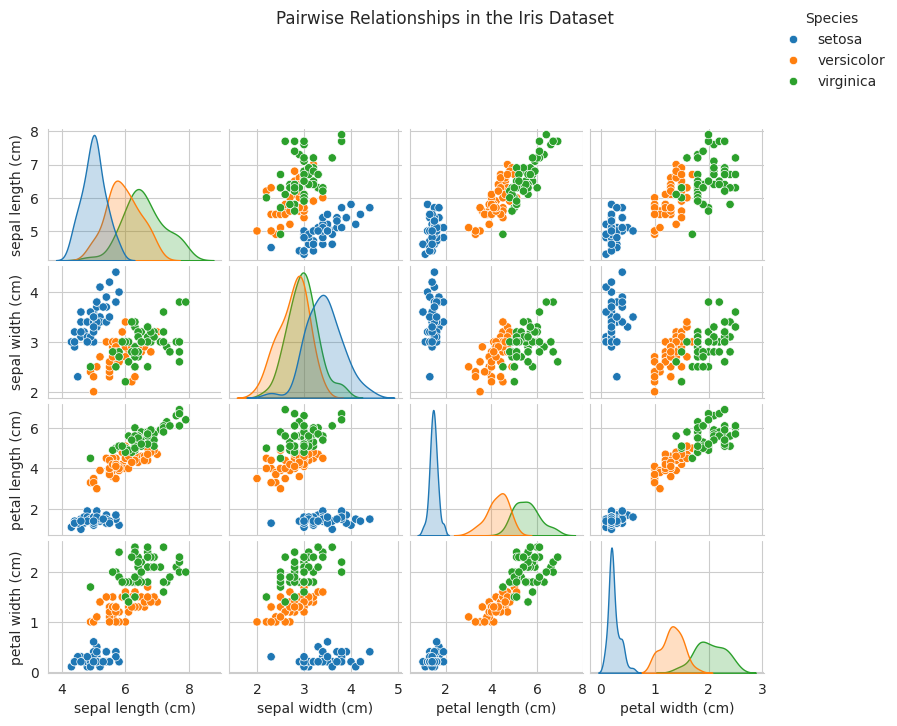


As can be observed, the 2 petal features ('petal width' & 'petal length') are strong classifiers by themselves;
they provide clear separation of the Iris Setosa class from the other 2 iris classes.
Next, run Mutual Information feature importance analysis (model-free) to validate this observation ...

Global Feature Importance (Mutual Information):
          Feature  Mutual Information
petal length (cm)            0.992573
 petal width (cm)            0.985643
sepal length (cm)            0.511365
 sepal width (cm)            0.299424


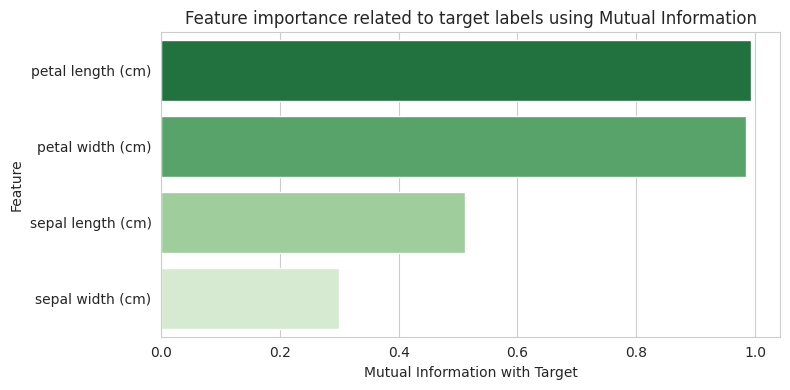

In [ ]:
# Load dataset
dataset = LoadDataset()
X, y = dataset.X, dataset.y
X_scaled = dataset.get_X_scaled()
dataset.run_EDA()

In [ ]:
# Web Researcher for the sklearn cluster model parameters
researcher = WebResearcher(genai_model=genai_model, agent_id=1)
researcher_output = researcher.act()

  WebResearcher Researching scikit-learn clustering documentation...
  WebResearcher         :  Sending prompt to Gemini model...
  WebResearcher         :  Received response from Gemini model.
  WebResearcher         : Raw response text: ```json{"KMeans":{"n_clusters":"int,>0(default:8)","init":"str,{'k-means++','random'}(default:'k-means++')","n_init":"int,>0(default:10)"},"GaussianMixture":{"n_components":"int,>0(default:1)","covariance_type":"str,{'full','tied','diag','spherical'}...
  WebResearcher         :  Clustering parameter dictionary summarized.
len(res_text): 1036
KMeans: n_clusters: int, > 0 (default: 8), init: str, {'k-means++', 'random'} (default: 'k-means++'), n_init: int, > 0 (default: 10)
GaussianMixture: n_components: int, > 0 (default: 1), covariance_type: str, {'full', 'tied', 'diag', 'spherical'} (default: 'full'), max_iter: int, > 0 (default: 100)
DBSCAN: eps: float, >= 0 (default: 1.0), min_samples: int, > 0 (default: 5)
AgglomerativeClustering: n_clusters: int

In [ ]:
# Fitness and Baseline Models setup
fitness_model = FitnessModel(X, y, X_scaled, dataset_name="Iris", n_features=X.shape[1], n_classes=len(np.unique(y)))
baseline_evaluator = BaselineModels(X, y, X_scaled, fitness_model)
baseline_evaluator.compute_baselines()
baseline_models = baseline_evaluator.baseline_models


--- Baseline ARI Scores ---
               ARI Score
Algorithm               
DBSCAN             0.631
KMeans             0.620
Agglomerative      0.615
GMM                0.516
Spectral           0.645
MeanShift          0.568
---------------------------


In [ ]:
# Initialize agents, runner, and evaluator
scout = ScoutBeeAgent(genai_model, fitness_model, baseline_models, n_candidates=12, sklearn_param_summary=researcher_output, agent_id=10000)
employed = EmployedBeeAgent(genai_model, fitness_model, n_variants=12, step_scale=0.2, sklearn_param_summary=researcher_output, agent_id=20000)
onlooker = OnlookerBeeAgent(genai_model, fitness_model, baseline_models, top_k=5, sklearn_param_summary=researcher_output, agent_id=30000)

runner = Runner(scout, employed, onlooker, fitness_model, baseline_models)
solution_pool, best_history = runner.run(iterations=8, pool_size=8, verbose=True)


Starting ABC run with Fitness Model for dataset: Iris
  Features: 4, Classes: 3
  Baseline Models (ARI): {'DBSCAN': 0.6309344087637648, 'KMeans': 0.6201351808870379, 'Agglomerative': 0.6153229932145449, 'GMM': 0.5164585360868599, 'Spectral': 0.6451422031981431, 'MeanShift': 0.5681159420289855}

Runner: Initiating Scout Agent for initial solutions...
  Scout Generating initial candidate solutions...
  Scout                 :  Sending prompt to Gemini model... n_candidates=12
  Scout                 :  Received response from Gemini model.
  Scout                 : Raw response text: ```json[{"model":"KMeans","params":{"n_clusters":3,"init":"k-means++","n_init":10,"random_state":42}},{"model":"KMeans","params":{"n_clusters":4,"init":"random","n_init":10,"random_state":42}},{"model":"KMeans","params":{"n_clusters":5,"init":"k-mean...
  Scout                 :  Initial candidates generated.
Runner: Scout Agent returned 12 initial solutions.

Runner: Starting iteration 1/8...
Runner: Agents

  candidate_model  candidate_ari  baseline_ari  improvement
0             GMM       0.885398      0.516459     0.368940
1             GMM       0.843631      0.516459     0.327172
2             GMM       0.843631      0.516459     0.327172
3             GMM       0.843631      0.516459     0.327172
4             GMM       0.843631      0.516459     0.327172
5             GMM       0.843631      0.516459     0.327172
6             GMM       0.843631      0.516459     0.327172
7             GMM       0.843631      0.516459     0.327172

Confusion Matrix for best solution: GMM, ARI: 0.8853984342844314
[[ 0  6 44  0]
 [ 2  0  0 48]
 [49  0  0  1]
 [ 0  0  0  0]]

Iteration: 0: Best Candidate: {'ari': 0.8202989638185834, 'model': 'GMM', 'params': {'n_components': 4, 'covariance_type': 'tied', 'max_iter': 100, 'random_state': 42}}
Iteration: 1: Best Candidate: {'ari': 0.8202989638185834, 'model': 'GMM', 'params': {'n_components': 4, 'covariance_type': 'tied', 'max_iter': 100, 'random_state':

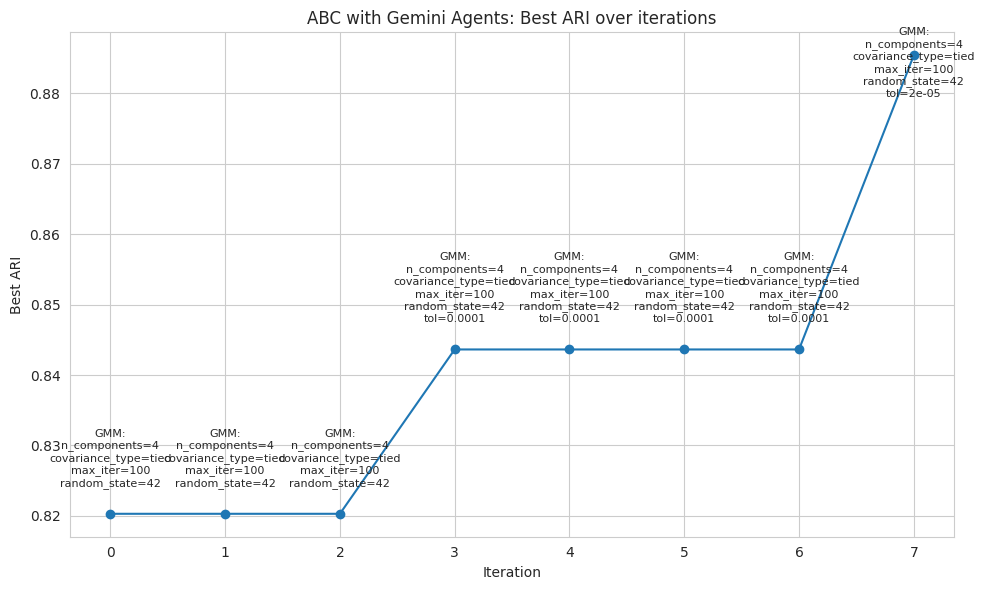

In [ ]:
# Compare and Report
evaluator = ComparisonEvaluator(fitness_model, baseline_models)
reporter = Reporter(evaluator)
reporter.report(solution_pool, best_history)